# Collaborative Filtering

Compared to other recommender systems such as content-based recommendation, __Collaborative Filtering__ doesn't need any information about the items and the users and recommend items based on the users' past behavior. In this notebook, we will use one of the several collaborative filtering approaches called __matrix factorization__, and the main idea is to separate a single matrix by finding two matrices whose product is equal to the original rating  matrix, and each of these two matrices are called the `embedding` or `latent factor`.

Dataset: [MovieLens rating dataset]( http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import sys

In [2]:
movies = pd.read_csv("utility/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv("utility/ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Randomly split data into training and test sets

In [4]:
def process(ratings, movies, P):
    ''' Given a dataframe of ratings and a random permutation, split the data into a training 
        and a testing set, in matrix form. 
        
        Args: 
            ratings (dataframe) : dataframe of MovieLens ratings
            movies (dataframe) : dataframe of MovieLens movies
            P (numpy 1D array) : random permutation vector
            
        Returns: 
            (X_tr, X_te, movie_names)  : training and testing splits of the ratings matrix (both 
                                         numpy 2D arrays), and a python list of movie names 
                                         corresponding to the columns of the ratings matrices. 
    '''
    tmp = ratings.merge(movies,on='movieId',how='left')
    movie_names = {movies.title[i]: i for i in range(movies.shape[0])}
    X_tr = np.zeros([len(tmp.userId.unique()),movies.shape[0]])
    X_te = np.zeros([len(tmp.userId.unique()),movies.shape[0]])
    
    num = int(np.floor(9*len(P)/10))
    for i in range(num):
        X_tr[tmp.userId[P[i]]-1,movie_names[tmp.title[P[i]]]] = tmp.rating[P[i]]
    for i in range(num,len(P)):
        X_te[tmp.userId[P[i]]-1,movie_names[tmp.title[P[i]]]] = tmp.rating[P[i]]
    
    return (X_tr, X_te, movie_names)

In [5]:
%time X_tr, X_te, movie_names = process(ratings,movies,np.random.permutation(len(ratings)))

Wall time: 5.93 s


In [6]:
def error(X, U, V):
    ''' Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each movie
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
    '''
    W = X > 0.0
    W[W == True] = 1
    W[W == False] = 0
    W = W.astype(np.float64,copy=False)
    return np.sum(W * (U@V.T-X)**2) / np.sum(W)

def train(X, X_te, k, U, V, niters=51, lam=10, verbose=False):
    ''' Train a collaborative filtering model. 
        Args:
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            X (numpy 2D array) : the training ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each movie
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    '''
    tr_log, te_log = [], []
    for i in range(niters):
        U = np.linalg.solve(V.T@V+lam*np.eye(k),(X@V).T).T
        V = np.linalg.solve(U.T@U+lam*np.eye(k),U.T@X).T
        tr_err = error(X, U, V)
        te_err = error(X_te, U, V)
        tr_log.append(tr_err)
        te_log.append(te_err)
        if verbose and i % 5 == 0:
            print('iteration: {0}, training error: {1}, test error: {2}'.format(i,tr_err,te_err))
    return (U, V, tr_log, te_log)

In [7]:
no_user, no_movies = X_tr.shape

In [8]:
user_features, movie_features, tr_log, te_log = \
train(X_tr, X_te, 5, 5 * np.random.rand(no_user,5), 5 * np.random.rand(no_movies,5),verbose=True)

iteration: 0, training error: 13.61296058775278, test error: 13.556299545845674
iteration: 5, training error: 8.238945350904611, test error: 8.835621207994333
iteration: 10, training error: 8.202270419888208, test error: 8.817290924053262
iteration: 15, training error: 8.204232424254833, test error: 8.827666675660174
iteration: 20, training error: 8.206913901232689, test error: 8.833594941972054
iteration: 25, training error: 8.208498290387713, test error: 8.836561223272803
iteration: 30, training error: 8.209443248616754, test error: 8.838114800944275
iteration: 35, training error: 8.210022169513705, test error: 8.838968197885551
iteration: 40, training error: 8.210382879942465, test error: 8.83945543865684
iteration: 45, training error: 8.210610035476023, test error: 8.839742271343138
iteration: 50, training error: 8.210754124020768, test error: 8.839915235529745


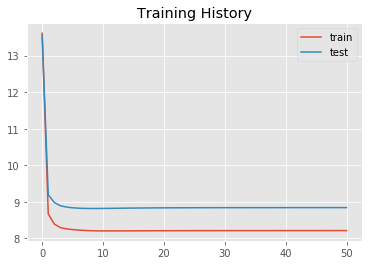

In [9]:
fig, ax = plt.subplots()
ax.plot(range(51),tr_log,label='train')
ax.plot(range(51),te_log,label='test')
plt.title('Training History')
plt.legend()

### Recommend each user with movie having the highest rating prediction

In [10]:
def recommend(X_tr, user_features, movie_features, movie_names):
    rec = []
    predict = user_features@movie_features.T
    for user_index in range(X_tr.shape[0]):
        max_rate = -sys.maxsize
        max_index = 0
        for rate_index in range(X_tr.shape[1]):
            if X_tr[user_index][rate_index] == 0 and predict[user_index][rate_index] > max_rate:
                max_rate = predict[user_index][rate_index]
                max_index = rate_index
        rec.append(movies.title[max_index])
    return rec

In [11]:
rec = recommend(X_tr,user_features,movie_features,movie_names)

In [12]:
rec[:10]

['Who Framed Roger Rabbit? (1988)',
 'Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Forrest Gump (1994)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Forrest Gump (1994)',
 'Matrix, The (1999)',
 'Pulp Fiction (1994)',
 'Star Wars: Episode IV - A New Hope (1977)']